In [1]:
import pandas as pd
import numpy as np

import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error



/opt/conda/lib/python3.6/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [2]:
csv = 'XAU_USD.csv'
start = '1985'
end = '2021'

In [3]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


In [4]:
def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se


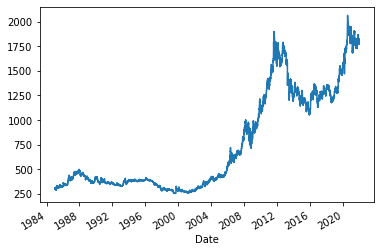

In [5]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price[start:end].plot()

In [6]:
true_ret = price.pct_change()
true_ret = true_ret[start:end]
true_ret

Date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [7]:
true_up = (true_ret>=0)
true_up

Date
1985-01-02    False
1985-01-03    False
1985-01-04     True
1985-01-07    False
1985-01-08     True
              ...  
2021-12-27     True
2021-12-28    False
2021-12-29    False
2021-12-30     True
2021-12-31     True
Name: adj_close, Length: 9612, dtype: bool

In [8]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


In [9]:
ewma = lambda x, y: x.ewm(span=y).mean()

In [10]:
pred_base = pd.DataFrame(1, index=true_ret.index, columns=['buy_and_hold'])
#pred_base

In [11]:
ld = [1,2,3,5,8,13,21,34,55,89,144,233,377,610,987]
lm = [l*21 for l in ld if l*21<1000]
ll = list(set(ld+lm))
ll.sort()

len(ll)


22

In [12]:
#ll = [1,2,3,5,8,13,21,34,55,89,144,233,377,610,987]
#len(ll)


In [13]:
ema_all = {'ema{}'.format(span): ewma(price.shift(), span) for span in ll}
ema_all = pd.DataFrame(ema_all)[start:end]
ema_all.shape

(9612, 22)

In [14]:
for fast in ll:
    name_fast = 'ema{}'.format(fast)
    for slow1 in ll:
        name_slow1 = 'ema{}'.format(slow1)
        for slow2 in ll:
            name_slow2 = 'ema{}'.format(slow2)
            if slow2 > slow1 and slow1 > fast:
                name_pred = 'cross_ema_{}_{}_{}'.format(fast, slow1, slow2)
                pred_tmp = (((ema_all[name_fast] > ema_all[name_slow1]) & (ema_all[name_fast] > ema_all[name_slow2]))*1)
                pred_base[name_pred] = pred_tmp[start:end]
pred_base.shape

(9612, 1541)

In [15]:
ret_base = pred_base.multiply(true_ret, 0)
ret_base.shape

(9612, 1541)

In [16]:
other_metric_base = other_metric(ret_base)
other_metric_base

,highlight_ratio,flip_ratio,accu,prec,mse
buy_and_hold,0.986371,0.026220,0.503329,0.510284,1.226646
cross_ema_1_2_3,0.471078,0.370929,0.467853,0.483878,1.251747
cross_ema_1_2_5,0.432688,0.339299,0.465668,0.479923,1.257247
cross_ema_1_2_8,0.401685,0.314952,0.466916,0.479927,1.261517
cross_ema_1_2_13,0.370474,0.289564,0.466500,0.477675,1.260320
...,...,...,...,...,...
cross_ema_377_714_987,0.537557,0.011757,0.513109,0.527966,1.238733
cross_ema_441_610_714,0.548793,0.011965,0.513525,0.527773,1.238167
cross_ema_441_610_987,0.525385,0.011549,0.513837,0.529307,1.238241
cross_ema_441_714_987,0.530275,0.011757,0.513733,0.528939,1.239963


In [17]:
other_metric_base.min()

highlight_ratio    0.321265
flip_ratio         0.009156
accu               0.465668
prec               0.476363
mse                1.222079
dtype: float64

In [18]:
other_metric_base.max()

highlight_ratio    0.986371
flip_ratio         0.370929
accu               0.522576
prec               0.535326
mse                1.277557
dtype: float64

In [19]:
try:
    empy_metric_base = pd.read_csv('empy_metric_of_all_cross_ema.csv', index_col=0)
except:
    empy_metric_base = empy_metric(ret_base)
    empy_metric_base.to_csv('empy_metric_of_all_cross_ema.csv')

empy_metric_base

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
cross_ema_1_2_3,1.300400,0.022081,0.254311,0.109279,-0.378008,-0.155260,0.058415,0.142222
cross_ema_1_2_5,0.802353,0.015564,0.198755,0.105696,-0.346822,-0.157533,0.044877,0.098800
cross_ema_1_2_8,0.498646,0.010663,0.155145,0.101463,-0.352232,-0.165296,0.030272,0.064508
cross_ema_1_2_13,0.605347,0.012487,0.175336,0.098196,-0.369996,-0.169794,0.033749,0.073542
...,...,...,...,...,...,...,...,...
cross_ema_377_714_987,3.012169,0.037096,0.360385,0.121650,-0.426216,-0.220630,0.087036,0.168136
cross_ema_441_610_714,3.104257,0.037713,0.363595,0.122496,-0.412021,-0.222791,0.091532,0.169276
cross_ema_441_610_987,3.123395,0.037840,0.368118,0.120743,-0.411897,-0.218027,0.091867,0.173555
cross_ema_441_714_987,2.788016,0.035534,0.348149,0.121569,-0.446217,-0.233127,0.079634,0.152424


In [20]:
empy_metric_base.min()

total_return        -0.276684
annual_return       -0.008456
sharpe_ratio        -0.042816
annual_volatility    0.092570
max_drawdown        -0.611006
avg_drawdown        -0.284528
return/maxdd        -0.019907
return/avgdd        -0.034247
dtype: float64

In [21]:
empy_metric_base.max()

total_return         7.676969
annual_return        0.058282
sharpe_ratio         0.518044
annual_volatility    0.155384
max_drawdown        -0.210295
avg_drawdown        -0.086763
return/maxdd         0.200892
return/avgdd         0.552046
dtype: float64

In [22]:
# rolling


roll_list = ['A','M']
lookback_list = [10,5,3,1]
top_n_list = [1,3,5,7]

#roll_list = ['M']
#lookback_list = [5]
#top_n_list = [1]

#top_n_name_list = ['vote_c3ema_roll_top{}'.format(n) for n in top_n_list]
#top_n_name_list = []

prob_sub = pd.DataFrame()
pred_sub = pd.DataFrame()

# init
chosen_dict = {}
for f in roll_list:
    for l in lookback_list:
        for n in top_n_list:
        
            top_n_name = 'vote_c3ema_roll{}_lookback{}_top{}'.format(f, l, n)

            chosen_dict[top_n_name] = pd.DataFrame()
            prob_sub[top_n_name] = pd.Series(0.5, ret_base.index)
            pred_sub[top_n_name] = pd.Series(1, ret_base.index)

for f in roll_list:
    
    
    
    met_y_name = 'met_{}.csv'.format(f)
    
    try:
        met_y = pd.read_csv(met_y_name, index_col=0)
    except:
        met_y = ret_base.groupby(pd.Grouper(freq=f)).apply(lambda x: empy_metric(x)['return/avgdd']).shift()
        met_y.to_csv(met_y_name)
    
    
    
    #met_y = ret_base.groupby(pd.Grouper(freq=f)).apply(lambda x: empy_metric(x)['return/avgdd']).shift()
    #display(met_y)
    
    
    
    
    
    
    
    for l in lookback_list:
        met_y = met_y.rolling(int(l), min_periods=1).sum()
        #display(met_y)
        
        print('vote_c3ema_roll{}_lookback{}'.format(f, l))
        
        for y, score in met_y.T.items():
            y_str = str(y)[:4] if 'A' in f else str(y)[:7]
            #print(y_str)
            top_idx_all = score.nlargest(max(top_n_list)).index
            if len(top_idx_all) == 0: 
                top_idx_all = ['buy_and_hold']


            for n in top_n_list:
                top_n_name = 'vote_c3ema_roll{}_lookback{}_top{}'.format(f, l, n)

                #print(top_n_name)

                #top_idx = score.nlargest(n).index
                top_idx = top_idx_all[:n]

                chosen_dict[top_n_name].loc[y_str, top_idx] = 1


                vote_df_tmp = pd.concat([pred_base[x][y_str] for x in top_idx], 1)
                prob_tmp = vote_df_tmp.mean(1)
                pred_tmp = prob_tmp.apply(lambda x: 0 if x<0.5 else 1)
                
                prob_sub.loc[y_str, top_n_name] = prob_tmp
                pred_sub.loc[y_str, top_n_name] = pred_tmp
                
    
for f in roll_list:
    for l in lookback_list:
        for n in top_n_list:

            top_n_name = 'vote_c3ema_roll{}_lookback{}_top{}'.format(f, l, n)

            chosen_dict[top_n_name] = chosen_dict[top_n_name].fillna(0)
    
#vote_se
#display(pred_sub)
#display(chosen_df)


/opt/conda/lib/python3.6/site-packages/empyrical/stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


vote_c3ema_rollA_lookback10
vote_c3ema_rollA_lookback5
vote_c3ema_rollA_lookback3
vote_c3ema_rollA_lookback1
vote_c3ema_rollM_lookback10
vote_c3ema_rollM_lookback5
vote_c3ema_rollM_lookback3
vote_c3ema_rollM_lookback1


In [44]:
pred_base.to_csv('prediction_all_simple_cross3ema.csv')
pred_base

,buy_and_hold,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_13,cross_ema_1_2_21,cross_ema_1_2_34,cross_ema_1_2_42,cross_ema_1_2_55,cross_ema_1_2_63,...,cross_ema_377_441_610,cross_ema_377_441_714,cross_ema_377_441_987,cross_ema_377_610_714,cross_ema_377_610_987,cross_ema_377_714_987,cross_ema_441_610_714,cross_ema_441_610_987,cross_ema_441_714_987,cross_ema_610_714_987
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-03,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-04,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-07,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-08,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2021-12-28,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2021-12-29,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [45]:
for f in roll_list:
    for l in lookback_list:
        for n in top_n_list:

            top_n_name = 'vote_c3ema_roll{}_lookback{}_top{}'.format(f, l, n)
            display(top_n_name)
            
            chosen_dict[top_n_name].to_csv('chosen_c3ema_of_{}.csv'.format(top_n_name))
            display(chosen_dict[top_n_name])

'vote_c3ema_rollA_lookback10_top1'

,buy_and_hold,cross_ema_89_105_168,cross_ema_441_610_714,cross_ema_377_441_714,cross_ema_610_714_987,cross_ema_377_610_714,cross_ema_168_273_714,cross_ema_42_105_273,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback10_top3'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_3_13_144,cross_ema_42_55_63,cross_ema_1_21_144,cross_ema_377_441_714,...,cross_ema_441_610_987,cross_ema_441_714_987,cross_ema_168_273_714,cross_ema_168_273_377,cross_ema_168_273_441,cross_ema_42_105_273,cross_ema_42_105_233,cross_ema_3_5_8,cross_ema_3_5_13,cross_ema_3_5_21
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback10_top5'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_2_13_987,cross_ema_5_13_987,...,cross_ema_168_273_441,cross_ema_168_273_610,cross_ema_168_273_987,cross_ema_42_105_273,cross_ema_42_105_233,cross_ema_3_5_8,cross_ema_3_5_13,cross_ema_3_5_21,cross_ema_2_5_8,cross_ema_3_8_13
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback10_top7'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_5_13_21,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,...,cross_ema_273_377_987,cross_ema_3_5_8,cross_ema_3_5_13,cross_ema_3_5_21,cross_ema_2_5_8,cross_ema_3_8_13,cross_ema_5_8_13,cross_ema_55_144_168,cross_ema_55_144_273,cross_ema_2_3_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback5_top1'

,buy_and_hold,cross_ema_89_105_168,cross_ema_441_610_714,cross_ema_377_441_714,cross_ema_610_714_987,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0
1986,0.0,1.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,1.0,0.0,0.0,0.0
1988,0.0,0.0,1.0,0.0,0.0,0.0
1989,0.0,0.0,1.0,0.0,0.0,0.0
1990,0.0,0.0,1.0,0.0,0.0,0.0
1991,0.0,0.0,1.0,0.0,0.0,0.0
1992,0.0,0.0,1.0,0.0,0.0,0.0
1993,0.0,0.0,1.0,0.0,0.0,0.0
1994,0.0,0.0,1.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback5_top3'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_3_13_144,cross_ema_42_55_63,cross_ema_377_441_714,cross_ema_377_610_714,cross_ema_377_441_610,cross_ema_610_714_987,cross_ema_441_610_987,cross_ema_441_714_987,cross_ema_233_273_987,cross_ema_273_377_987,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback5_top5'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_2_13_987,cross_ema_5_13_987,...,cross_ema_105_377_610,cross_ema_2_8_273,cross_ema_105_441_610,cross_ema_168_273_377,cross_ema_168_273_441,cross_ema_273_377_987,cross_ema_273_377_714,cross_ema_273_714_987,cross_ema_3_5_21,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback5_top7'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_5_13_21,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,...,cross_ema_2_8_273,cross_ema_2_5_714,cross_ema_233_273_377,cross_ema_168_273_377,cross_ema_168_273_441,cross_ema_273_377_987,cross_ema_273_714_987,cross_ema_273_441_987,cross_ema_3_5_21,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback3_top1'

,buy_and_hold,cross_ema_89_105_168,cross_ema_441_610_714,cross_ema_377_441_714,cross_ema_610_714_987
1985,1.0,0.0,0.0,0.0,0.0
1986,0.0,1.0,0.0,0.0,0.0
1987,0.0,0.0,1.0,0.0,0.0
1988,0.0,0.0,1.0,0.0,0.0
1989,0.0,0.0,1.0,0.0,0.0
1990,0.0,0.0,1.0,0.0,0.0
1991,0.0,0.0,1.0,0.0,0.0
1992,0.0,0.0,1.0,0.0,0.0
1993,0.0,0.0,1.0,0.0,0.0
1994,0.0,0.0,1.0,0.0,0.0


'vote_c3ema_rollA_lookback3_top3'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_3_13_144,cross_ema_42_55_63,cross_ema_377_441_714,cross_ema_377_610_714,cross_ema_377_441_610,cross_ema_610_714_987,cross_ema_441_610_987,cross_ema_441_714_987
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback3_top5'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_2_13_987,cross_ema_5_13_987,...,cross_ema_233_377_987,cross_ema_233_273_987,cross_ema_610_714_987,cross_ema_441_610_987,cross_ema_441_714_987,cross_ema_2_5_273,cross_ema_105_377_610,cross_ema_105_441_610,cross_ema_273_377_987,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback3_top7'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_5_13_21,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,...,cross_ema_105_441_610,cross_ema_2_5_714,cross_ema_233_273_377,cross_ema_144_377_441,cross_ema_168_273_377,cross_ema_273_377_987,cross_ema_273_714_987,cross_ema_273_441_987,cross_ema_3_5_21,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback1_top1'

,buy_and_hold,cross_ema_89_105_168,cross_ema_441_610_714,cross_ema_377_441_714,cross_ema_610_714_987
1985,1.0,0.0,0.0,0.0,0.0
1986,0.0,1.0,0.0,0.0,0.0
1987,0.0,0.0,1.0,0.0,0.0
1988,0.0,0.0,1.0,0.0,0.0
1989,0.0,0.0,1.0,0.0,0.0
1990,0.0,0.0,1.0,0.0,0.0
1991,0.0,0.0,1.0,0.0,0.0
1992,0.0,0.0,1.0,0.0,0.0
1993,0.0,0.0,1.0,0.0,0.0
1994,0.0,0.0,1.0,0.0,0.0


'vote_c3ema_rollA_lookback1_top3'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_3_13_144,cross_ema_42_55_63,cross_ema_377_441_714,cross_ema_377_610_714,cross_ema_377_441_610,cross_ema_610_714_987,cross_ema_441_610_987,cross_ema_441_714_987
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback1_top5'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,cross_ema_2_13_987,cross_ema_5_13_987,...,cross_ema_233_377_987,cross_ema_233_273_987,cross_ema_610_714_987,cross_ema_441_610_987,cross_ema_441_714_987,cross_ema_2_5_273,cross_ema_105_377_610,cross_ema_105_441_610,cross_ema_273_377_987,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback1_top7'

,buy_and_hold,cross_ema_89_105_168,cross_ema_89_144_168,cross_ema_1_2_3,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_5_13_21,cross_ema_441_610_714,cross_ema_3_13_987,cross_ema_5_8_987,...,cross_ema_105_441_610,cross_ema_2_5_714,cross_ema_233_273_377,cross_ema_144_377_441,cross_ema_168_273_377,cross_ema_273_377_987,cross_ema_273_714_987,cross_ema_273_441_987,cross_ema_3_5_21,cross_ema_3_5_8
1985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollM_lookback10_top1'

,buy_and_hold,cross_ema_1_2_13,cross_ema_8_13_89,cross_ema_13_55_63,cross_ema_8_21_89,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_42_55_987,cross_ema_42_89_987,cross_ema_21_34_55,...,cross_ema_144_273_441,cross_ema_13_21_273,cross_ema_105_144_987,cross_ema_1_2_3,cross_ema_55_144_714,cross_ema_55_168_714,cross_ema_8_63_273,cross_ema_8_63_105,cross_ema_8_34_63,cross_ema_63_89_233
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


'vote_c3ema_rollM_lookback10_top3'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_8_34_89,cross_ema_13_55_63,cross_ema_21_34_42,cross_ema_8_42_89,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_63_233,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_34_63,cross_ema_8_42_63,cross_ema_63_89_233,cross_ema_63_89_377,cross_ema_63_89_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


'vote_c3ema_rollM_lookback10_top5'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_21,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_8_34_89,cross_ema_8_42_89,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_63_610,cross_ema_8_34_63,cross_ema_8_42_63,cross_ema_63_89_377,cross_ema_63_89_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


'vote_c3ema_rollM_lookback10_top7'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_8,cross_ema_2_5_8,cross_ema_2_3_21,cross_ema_2_5_21,cross_ema_2_8_21,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_42_168,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_63_610,cross_ema_8_34_63,cross_ema_8_42_63,cross_ema_63_89_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


'vote_c3ema_rollM_lookback5_top1'

,buy_and_hold,cross_ema_1_2_13,cross_ema_13_55_63,cross_ema_8_21_89,cross_ema_8_13_89,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_42_55_987,cross_ema_42_89_987,cross_ema_2_13_42,...,cross_ema_13_21_273,cross_ema_105_144_987,cross_ema_1_2_3,cross_ema_55_144_714,cross_ema_55_168_714,cross_ema_8_63_273,cross_ema_8_63_105,cross_ema_8_63_144,cross_ema_8_42_63,cross_ema_8_34_63
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollM_lookback5_top3'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_13_55_63,cross_ema_21_34_42,cross_ema_8_42_89,cross_ema_8_34_89,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_63_233,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_8_63_89,cross_ema_63_89_377,cross_ema_63_89_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


'vote_c3ema_rollM_lookback5_top5'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_21,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_8_34_89,cross_ema_8_42_89,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_63_89,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_63_89_377,cross_ema_63_89_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


'vote_c3ema_rollM_lookback5_top7'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_8,cross_ema_2_5_8,cross_ema_2_3_21,cross_ema_2_5_21,cross_ema_2_8_21,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_42_168,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_63_610,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_63_89_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


'vote_c3ema_rollM_lookback3_top1'

,buy_and_hold,cross_ema_1_2_13,cross_ema_13_55_63,cross_ema_8_21_89,cross_ema_8_13_89,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_42_55_987,cross_ema_42_89_987,cross_ema_2_13_34,...,cross_ema_1_2_3,cross_ema_55_144_714,cross_ema_55_273_714,cross_ema_8_63_273,cross_ema_8_63_89,cross_ema_8_63_105,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_63_89_441,cross_ema_63_89_610
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


'vote_c3ema_rollM_lookback3_top3'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_13_55_63,cross_ema_21_34_42,cross_ema_8_42_89,cross_ema_8_34_89,...,cross_ema_55_233_714,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_63_233,cross_ema_8_63_89,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_63_89_377
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


'vote_c3ema_rollM_lookback3_top5'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_21,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_8_34_89,cross_ema_8_42_89,...,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_63_89,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_8_63_610,cross_ema_63_89_377
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


'vote_c3ema_rollM_lookback3_top7'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_8,cross_ema_2_5_8,cross_ema_2_3_21,cross_ema_2_5_21,cross_ema_2_8_21,...,cross_ema_8_42_168,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_8_63_610,cross_ema_8_63_441,cross_ema_8_63_714,cross_ema_63_89_377,cross_ema_63_89_233
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


'vote_c3ema_rollM_lookback1_top1'

,buy_and_hold,cross_ema_1_2_13,cross_ema_13_55_63,cross_ema_8_21_89,cross_ema_8_13_89,cross_ema_1_2_5,cross_ema_1_3_5,cross_ema_42_55_987,cross_ema_42_89_987,cross_ema_2_13_34,...,cross_ema_144_273_441,cross_ema_13_21_273,cross_ema_105_144_987,cross_ema_1_2_3,cross_ema_55_144_714,cross_ema_55_168_714,cross_ema_8_63_273,cross_ema_8_63_105,cross_ema_8_42_63,cross_ema_8_34_63
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollM_lookback1_top3'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_13_55_63,cross_ema_21_34_42,cross_ema_8_42_89,cross_ema_8_34_89,...,cross_ema_55_233_714,cross_ema_55_377_714,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_63_233,cross_ema_8_63_377,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_8_63_89,cross_ema_63_89_233
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


'vote_c3ema_rollM_lookback1_top5'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_21,cross_ema_8_13_89,cross_ema_8_21_89,cross_ema_8_34_89,cross_ema_8_42_89,...,cross_ema_55_441_714,cross_ema_8_63_273,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_63_89,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_8_63_610
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollM_lookback1_top7'

,buy_and_hold,cross_ema_1_2_13,cross_ema_1_2_5,cross_ema_1_2_8,cross_ema_1_2_3,cross_ema_2_3_8,cross_ema_2_5_8,cross_ema_2_3_21,cross_ema_2_5_21,cross_ema_2_8_21,...,cross_ema_8_42_273,cross_ema_8_42_233,cross_ema_8_42_168,cross_ema_8_63_377,cross_ema_8_63_987,cross_ema_8_63_610,cross_ema_8_63_441,cross_ema_8_42_63,cross_ema_8_34_63,cross_ema_8_63_714
1985-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-03,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'vote_c3ema_rollA_lookback10_top1'

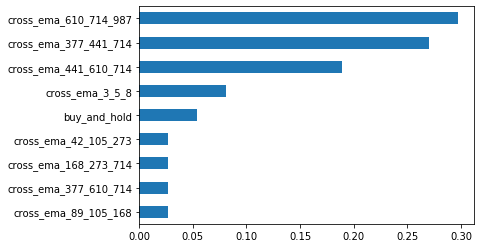

'vote_c3ema_rollA_lookback10_top3'

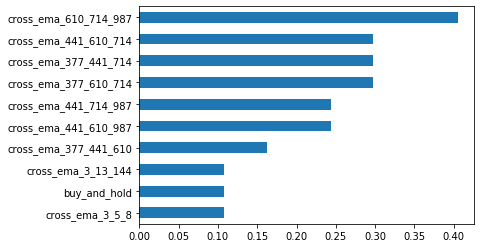

'vote_c3ema_rollA_lookback10_top5'

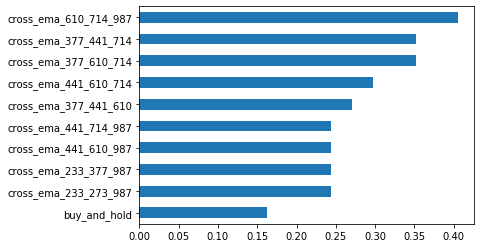

'vote_c3ema_rollA_lookback10_top7'

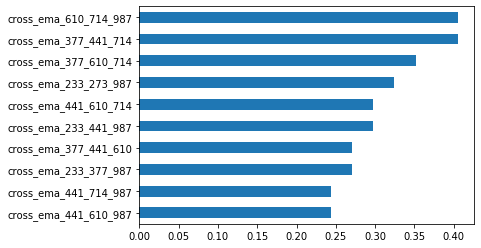

'vote_c3ema_rollA_lookback5_top1'

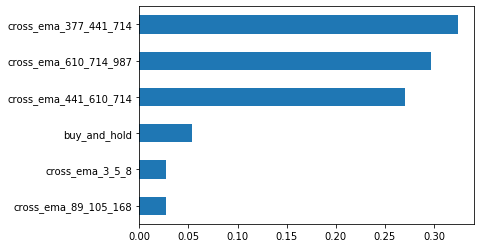

'vote_c3ema_rollA_lookback5_top3'

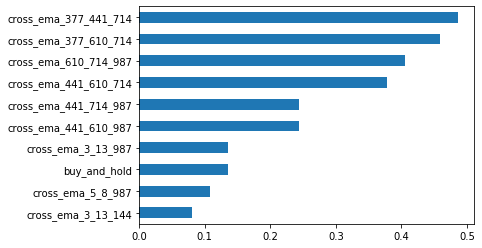

'vote_c3ema_rollA_lookback5_top5'

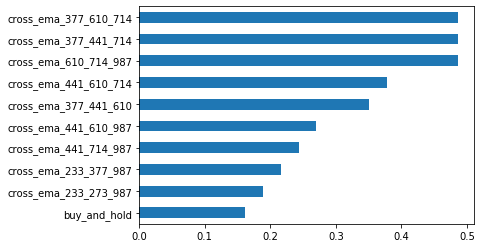

'vote_c3ema_rollA_lookback5_top7'

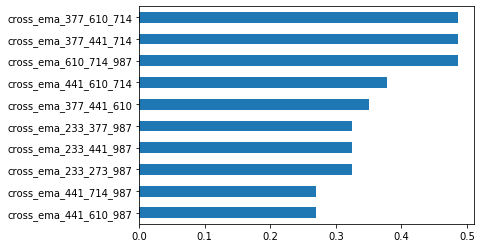

'vote_c3ema_rollA_lookback3_top1'

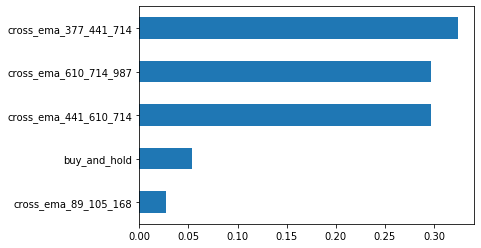

'vote_c3ema_rollA_lookback3_top3'

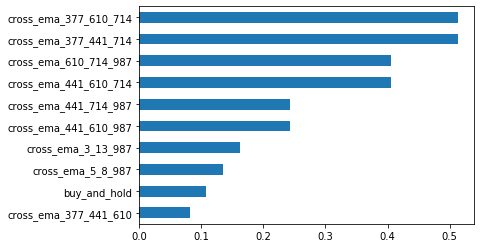

'vote_c3ema_rollA_lookback3_top5'

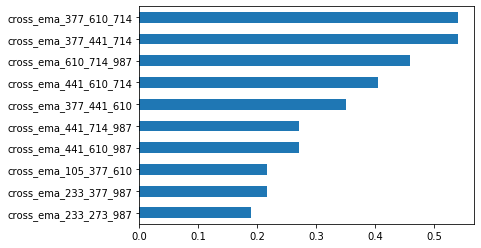

'vote_c3ema_rollA_lookback3_top7'

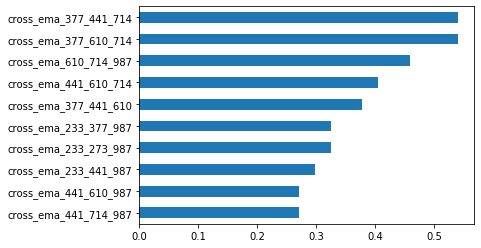

'vote_c3ema_rollA_lookback1_top1'

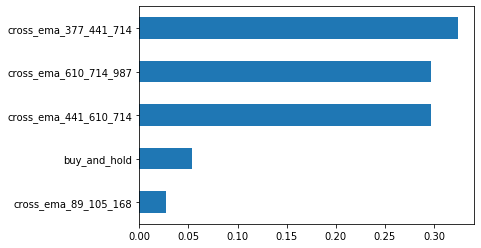

'vote_c3ema_rollA_lookback1_top3'

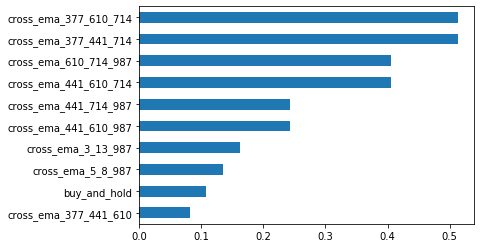

'vote_c3ema_rollA_lookback1_top5'

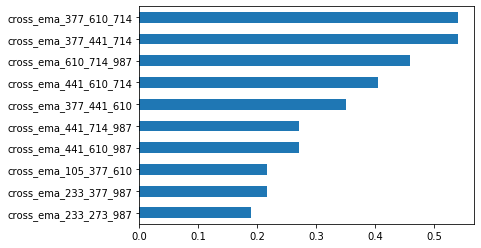

'vote_c3ema_rollA_lookback1_top7'

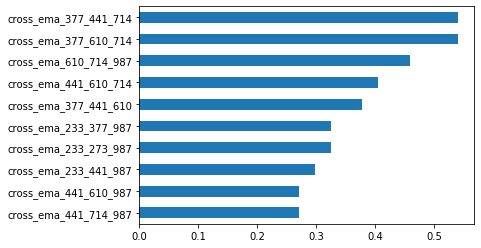

'vote_c3ema_rollM_lookback10_top1'

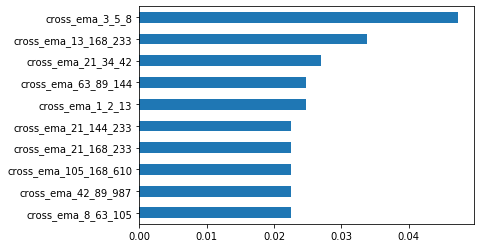

'vote_c3ema_rollM_lookback10_top3'

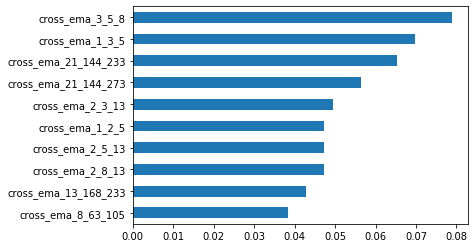

'vote_c3ema_rollM_lookback10_top5'

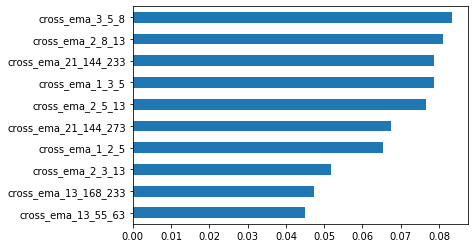

'vote_c3ema_rollM_lookback10_top7'

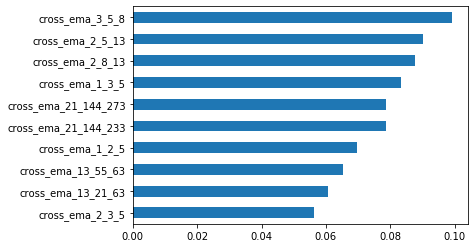

'vote_c3ema_rollM_lookback5_top1'

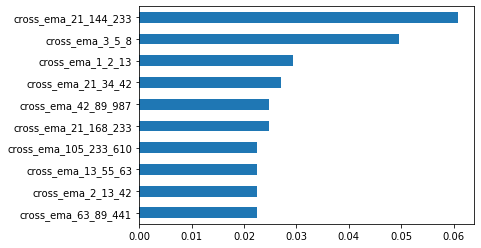

'vote_c3ema_rollM_lookback5_top3'

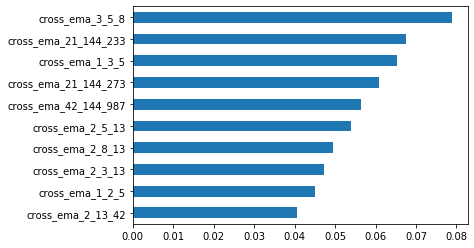

'vote_c3ema_rollM_lookback5_top5'

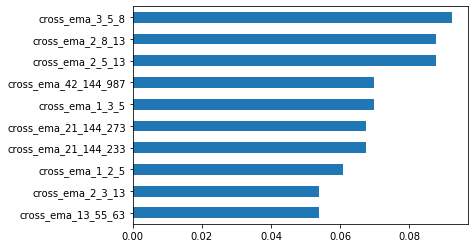

'vote_c3ema_rollM_lookback5_top7'

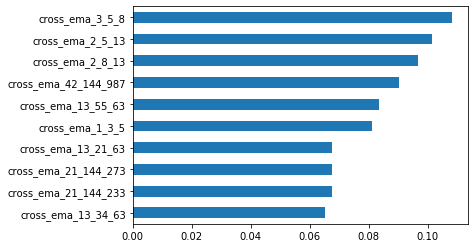

'vote_c3ema_rollM_lookback3_top1'

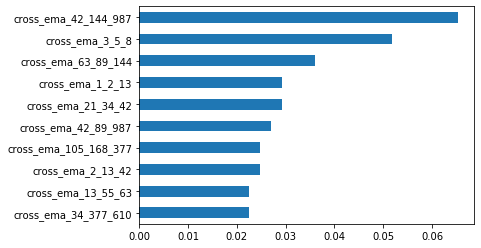

'vote_c3ema_rollM_lookback3_top3'

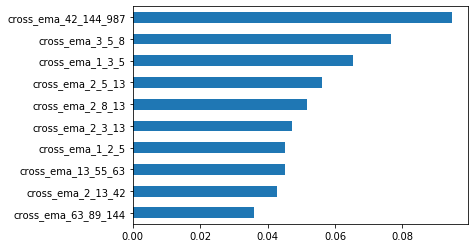

'vote_c3ema_rollM_lookback3_top5'

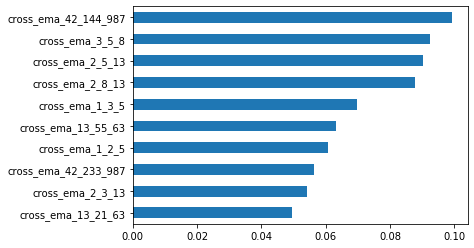

'vote_c3ema_rollM_lookback3_top7'

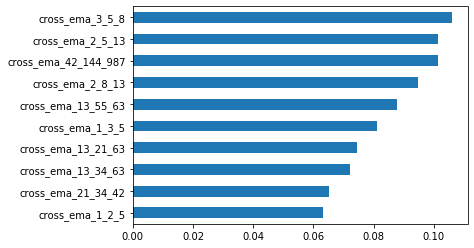

'vote_c3ema_rollM_lookback1_top1'

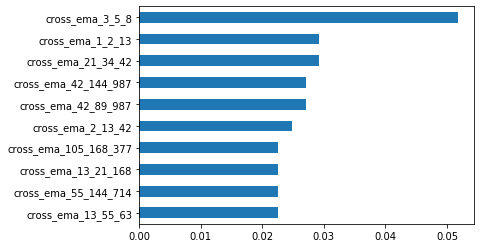

'vote_c3ema_rollM_lookback1_top3'

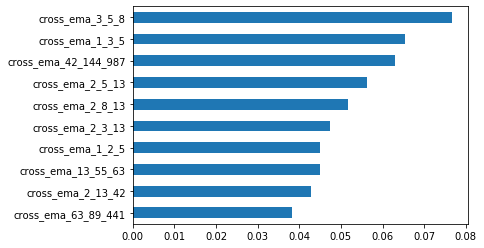

'vote_c3ema_rollM_lookback1_top5'

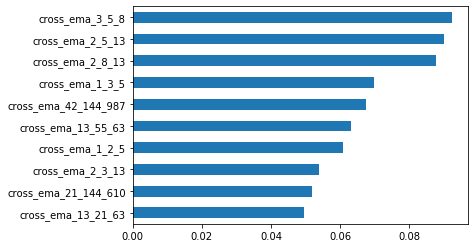

'vote_c3ema_rollM_lookback1_top7'

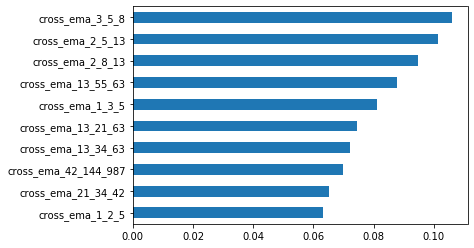

In [23]:

for f in roll_list:
    for l in lookback_list:
        for n in top_n_list:

            top_n_name = 'vote_c3ema_roll{}_lookback{}_top{}'.format(f, l, n)

            display(top_n_name)
            #display(chosen_df[(f, n)].mean().sort_values())

            fig, ax = plt.subplots()
            chosen_dict[top_n_name].mean().sort_values().iloc[-10:].plot.barh()
            #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
        

In [24]:
prob_sub.to_csv('prob_sub_cross_3ema_rolling_extend_ll-Copy1.csv')
prob_sub

,vote_c3ema_rollA_lookback10_top1,vote_c3ema_rollA_lookback10_top3,vote_c3ema_rollA_lookback10_top5,vote_c3ema_rollA_lookback10_top7,vote_c3ema_rollA_lookback5_top1,vote_c3ema_rollA_lookback5_top3,vote_c3ema_rollA_lookback5_top5,vote_c3ema_rollA_lookback5_top7,vote_c3ema_rollA_lookback3_top1,vote_c3ema_rollA_lookback3_top3,...,vote_c3ema_rollM_lookback5_top5,vote_c3ema_rollM_lookback5_top7,vote_c3ema_rollM_lookback3_top1,vote_c3ema_rollM_lookback3_top3,vote_c3ema_rollM_lookback3_top5,vote_c3ema_rollM_lookback3_top7,vote_c3ema_rollM_lookback1_top1,vote_c3ema_rollM_lookback1_top3,vote_c3ema_rollM_lookback1_top5,vote_c3ema_rollM_lookback1_top7
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-02,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1985-01-03,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1985-01-04,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1985-01-07,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
1985-01-08,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2021-12-28,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.857143,1.0,1.0,1.0,0.857143,1.0,1.0,0.8,0.857143
2021-12-29,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.857143,1.0,1.0,1.0,0.857143,1.0,1.0,0.8,0.857143


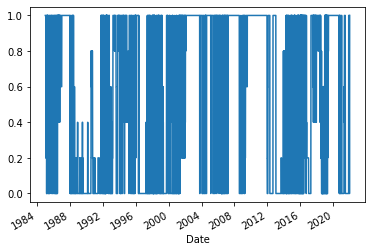

In [40]:
prob_sub['vote_c3ema_rollM_lookback1_top5'].plot()

In [25]:
pred_sub.to_csv('pred_sub_cross_3ema_rolling_extend_ll-Copy1.csv')
pred_sub


,vote_c3ema_rollA_lookback10_top1,vote_c3ema_rollA_lookback10_top3,vote_c3ema_rollA_lookback10_top5,vote_c3ema_rollA_lookback10_top7,vote_c3ema_rollA_lookback5_top1,vote_c3ema_rollA_lookback5_top3,vote_c3ema_rollA_lookback5_top5,vote_c3ema_rollA_lookback5_top7,vote_c3ema_rollA_lookback3_top1,vote_c3ema_rollA_lookback3_top3,...,vote_c3ema_rollM_lookback5_top5,vote_c3ema_rollM_lookback5_top7,vote_c3ema_rollM_lookback3_top1,vote_c3ema_rollM_lookback3_top3,vote_c3ema_rollM_lookback3_top5,vote_c3ema_rollM_lookback3_top7,vote_c3ema_rollM_lookback1_top1,vote_c3ema_rollM_lookback1_top3,vote_c3ema_rollM_lookback1_top5,vote_c3ema_rollM_lookback1_top7
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-02,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1985-01-03,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1985-01-04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1985-01-07,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1985-01-08,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2021-12-28,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2021-12-29,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [26]:
ret_sub = pred_sub.multiply(true_ret, 0)
ret_sub.shape

(9612, 32)

In [27]:
other_metric_sub = other_metric(ret_sub)
other_metric_sub

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback10_top1,0.584270,0.029966,0.512588,0.525285,1.233953
vote_c3ema_rollA_lookback10_top3,0.596650,0.032879,0.513317,0.525371,1.235286
vote_c3ema_rollA_lookback10_top5,0.602268,0.033711,0.512484,0.524443,1.237825
vote_c3ema_rollA_lookback10_top7,0.569288,0.044948,0.508843,0.522661,1.246053
vote_c3ema_rollA_lookback5_top1,0.598107,0.019977,0.517270,0.528614,1.229832
vote_c3ema_rollA_lookback5_top3,0.593113,0.022058,0.517270,0.528855,1.231711
vote_c3ema_rollA_lookback5_top5,0.597378,0.022890,0.515501,0.527168,1.231702
vote_c3ema_rollA_lookback5_top7,0.600707,0.026428,0.513213,0.525113,1.236405
vote_c3ema_rollA_lookback3_top1,0.603204,0.016023,0.516334,0.527596,1.232486
vote_c3ema_rollA_lookback3_top3,0.580108,0.021642,0.515501,0.527977,1.232692


In [28]:
empy_metric_sub = empy_metric(ret_sub)
empy_metric_sub

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
vote_c3ema_rollA_lookback10_top1,3.878887,0.042428,0.389096,0.127825,-0.422441,-0.219730,0.100434,0.193089
vote_c3ema_rollA_lookback10_top3,3.517621,0.040327,0.368079,0.130656,-0.497486,-0.178133,0.081062,0.226388
vote_c3ema_rollA_lookback10_top5,3.010574,0.037085,0.344322,0.130579,-0.493742,-0.214944,0.075110,0.172534
vote_c3ema_rollA_lookback10_top7,1.790977,0.027274,0.277280,0.125554,-0.499114,-0.227200,0.054646,0.120046
vote_c3ema_rollA_lookback5_top1,4.880665,0.047544,0.424073,0.129267,-0.397101,-0.210319,0.119727,0.226056
vote_c3ema_rollA_lookback5_top3,4.349025,0.044945,0.402301,0.130503,-0.436270,-0.186626,0.103021,0.240828
vote_c3ema_rollA_lookback5_top5,4.350047,0.044950,0.402231,0.130554,-0.401333,-0.200060,0.112002,0.224682
vote_c3ema_rollA_lookback5_top7,3.276340,0.038831,0.356276,0.131111,-0.488651,-0.222833,0.079466,0.174261
vote_c3ema_rollA_lookback3_top1,4.171070,0.044018,0.396438,0.130021,-0.422249,-0.224568,0.104247,0.196013
vote_c3ema_rollA_lookback3_top3,4.118091,0.043736,0.394253,0.130098,-0.455900,-0.191403,0.095934,0.228504


In [29]:
pred_all = pd.concat([pred_base, pred_sub], 1)
pred_all.shape

(9612, 1573)

In [30]:
ret_all = pd.concat([ret_base, ret_sub], 1)
ret_all.shape

(9612, 1573)

In [31]:
other_metric_all = pd.concat([other_metric_base, other_metric_sub])
other_metric_all.shape

(1573, 5)

In [32]:
empy_metric_all = pd.concat([empy_metric_base, empy_metric_sub])
empy_metric_all.shape

(1573, 8)

In [35]:
def print_all_result(ret_df, topn=10):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return','sharpe_ratio','avg_drawdown','return/avgdd',]
    
    empy_metric_tmp = empy_metric(ret_df).sort_values('return/avgdd')
    
    strategy_list_sel = list(empy_metric_tmp.index)

    strategy_list_sel = strategy_list_sel[-topn:]
    
    if 'buy_and_hold' in strategy_list_sel:
        strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    strategy_list_sel = ['buy_and_hold']+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
    

In [ ]:
### base only, return/avgdd top10
list_tmp = [x for x in ret_all.columns if (
    x=='buy_and_hold' 
    or 'vote_c3ema_' not in x
)]
ret_tmp = ret_all[list_tmp]
print_all_result(ret_tmp)

print_all_result(ret_tmp['1988':'2000'])
print_all_result(ret_tmp['2001':'2011'])
print_all_result(ret_tmp['2012':'2015'])
print_all_result(ret_tmp['2016':'2021'])


'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollM_lookback5_top1,0.628279,0.109475,0.503519,0.531568,1.266719


,annual_return,sharpe_ratio,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.066784,1.372467
vote_c3ema_rollM_lookback5_top1,0.026294,0.291071,-0.113072,0.232537


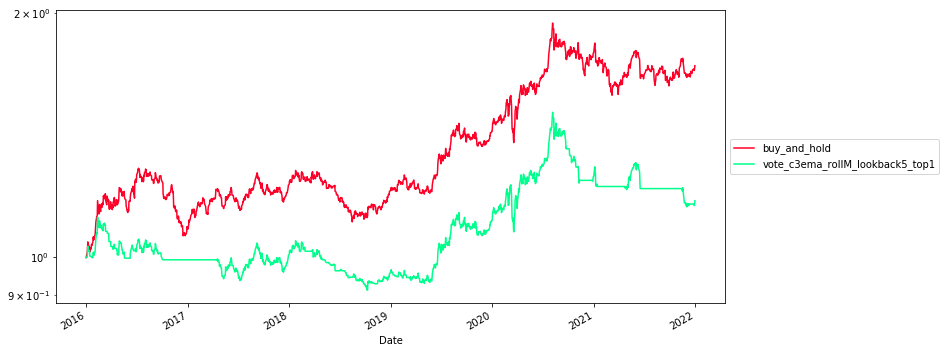

In [36]:
list_tmp = ['buy_and_hold', 'vote_c3ema_rollM_lookback5_top1']
ret_tmp = ret_all[list_tmp]
print_all_result(ret_tmp['2016':'2021'])

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top5,0.584478,0.021642,0.515710,0.527946,1.230647
vote_c3ema_rollA_lookback1_top5,0.584478,0.021642,0.515710,0.527946,1.230647
vote_c3ema_rollM_lookback1_top7,0.531107,0.069920,0.498543,0.514594,1.238679
vote_c3ema_rollM_lookback5_top3,0.535893,0.075538,0.500208,0.516016,1.239272
vote_c3ema_rollM_lookback1_top5,0.528194,0.078452,0.497711,0.513886,1.238314
vote_c3ema_rollM_lookback3_top5,0.528194,0.078452,0.497711,0.513886,1.238314
vote_c3ema_rollM_lookback3_top7,0.531627,0.069920,0.498439,0.514481,1.238140
vote_c3ema_rollM_lookback3_top3,0.536101,0.076579,0.500624,0.516398,1.237477
vote_c3ema_rollM_lookback1_top3,0.534644,0.076579,0.501040,0.516832,1.237292
vote_c3ema_rollM_lookback10_top1,0.528922,0.075330,0.498648,0.514752,1.237345


,annual_return,sharpe_ratio,avg_drawdown,return/avgdd
buy_and_hold,0.047776,0.378081,-0.224901,0.212431
vote_c3ema_rollA_lookback3_top5,0.046378,0.413775,-0.176478,0.262795
vote_c3ema_rollA_lookback1_top5,0.046378,0.413775,-0.176478,0.262795
vote_c3ema_rollM_lookback1_top7,0.037326,0.364332,-0.141287,0.264189
vote_c3ema_rollM_lookback5_top3,0.036738,0.362372,-0.137560,0.267068
vote_c3ema_rollM_lookback1_top5,0.037924,0.371281,-0.139186,0.272470
vote_c3ema_rollM_lookback3_top5,0.037924,0.371281,-0.139186,0.272470
vote_c3ema_rollM_lookback3_top7,0.038010,0.369684,-0.136921,0.277603
vote_c3ema_rollM_lookback3_top3,0.039193,0.385256,-0.140277,0.279396
vote_c3ema_rollM_lookback1_top3,0.039448,0.387706,-0.138996,0.283810


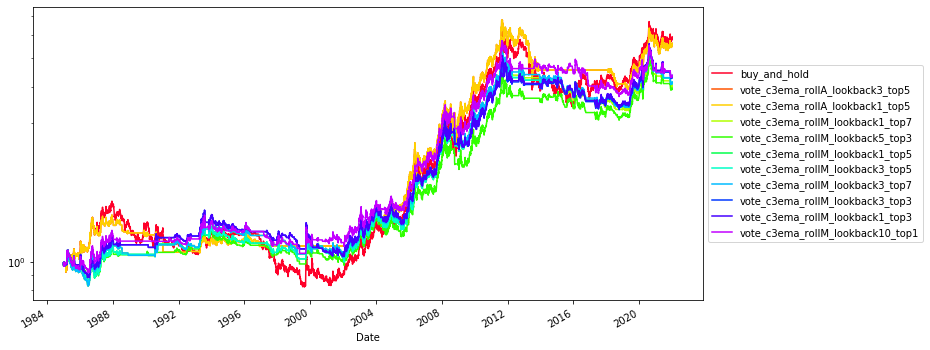

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollM_lookback5_top5,0.272566,0.061279,0.485351,0.450597,1.236297
vote_c3ema_rollM_lookback5_top7,0.280852,0.063647,0.486534,0.454162,1.235101
vote_c3ema_rollM_lookback3_top7,0.288547,0.067200,0.485351,0.453333,1.234133
vote_c3ema_rollM_lookback1_top7,0.288547,0.067200,0.485351,0.453333,1.234133
vote_c3ema_rollM_lookback5_top3,0.288843,0.061871,0.488606,0.459016,1.235253
vote_c3ema_rollM_lookback5_top1,0.286179,0.061279,0.487718,0.457084,1.234653
vote_c3ema_rollM_lookback10_top1,0.290027,0.061279,0.487422,0.457143,1.233008
vote_c3ema_rollM_lookback10_top3,0.296241,0.062463,0.490086,0.462537,1.232938
vote_c3ema_rollM_lookback3_top5,0.282332,0.067792,0.483871,0.449686,1.232469
vote_c3ema_rollM_lookback1_top5,0.282332,0.067792,0.483871,0.449686,1.232469


,annual_return,sharpe_ratio,avg_drawdown,return/avgdd
buy_and_hold,-0.042235,-0.283945,-0.272448,-0.155021
vote_c3ema_rollM_lookback5_top5,-0.007091,-0.052805,-0.118884,-0.059650
vote_c3ema_rollM_lookback5_top7,-0.006017,-0.037003,-0.106107,-0.056709
vote_c3ema_rollM_lookback3_top7,-0.005185,-0.024446,-0.099833,-0.051939
vote_c3ema_rollM_lookback1_top7,-0.005185,-0.024446,-0.099833,-0.051939
vote_c3ema_rollM_lookback5_top3,-0.006137,-0.039082,-0.121738,-0.050412
vote_c3ema_rollM_lookback5_top1,-0.005409,-0.032271,-0.110541,-0.048935
vote_c3ema_rollM_lookback10_top1,-0.003735,-0.011272,-0.107084,-0.034877
vote_c3ema_rollM_lookback10_top3,-0.003720,-0.010280,-0.115807,-0.032120
vote_c3ema_rollM_lookback3_top5,-0.003469,-0.004114,-0.109916,-0.031562


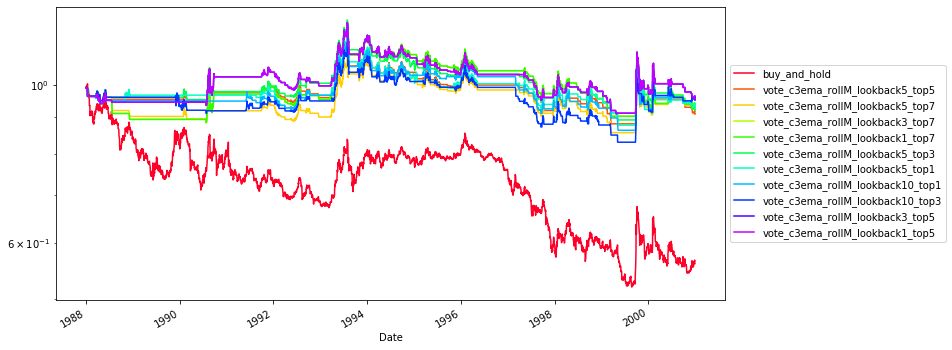

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top3,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback3_top1,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback5_top5,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback5_top3,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback5_top1,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback10_top5,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback10_top3,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback10_top1,0.869064,0.009431,0.532123,0.543592,1.20533
vote_c3ema_rollA_lookback1_top5,0.869064,0.009431,0.532123,0.543592,1.20533


,annual_return,sharpe_ratio,avg_drawdown,return/avgdd
buy_and_hold,0.166255,0.914087,-0.057719,2.880430
vote_c3ema_rollA_lookback3_top3,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback3_top1,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback5_top5,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback5_top3,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback5_top1,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback10_top5,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback10_top3,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback10_top1,0.150511,0.865565,-0.053233,2.827429
vote_c3ema_rollA_lookback1_top5,0.150511,0.865565,-0.053233,2.827429


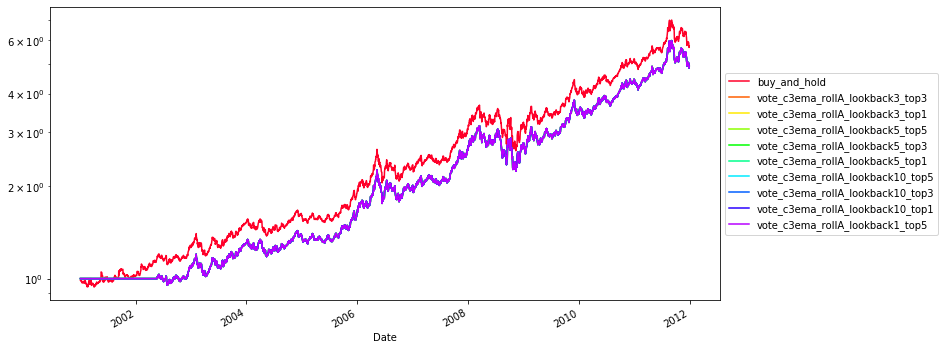

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback5_top7,0.467370,0.000961,0.518234,0.503080,1.250428
vote_c3ema_rollA_lookback1_top5,0.467370,0.000961,0.518234,0.503080,1.250428
vote_c3ema_rollA_lookback1_top7,0.467370,0.000961,0.518234,0.503080,1.250428
vote_c3ema_rollA_lookback1_top1,0.590211,0.000961,0.533589,0.515447,1.246954
vote_c3ema_rollA_lookback5_top1,0.590211,0.000961,0.533589,0.515447,1.246954
vote_c3ema_rollA_lookback3_top1,0.590211,0.000961,0.533589,0.515447,1.246954
vote_c3ema_rollA_lookback10_top7,0.387716,0.000961,0.523033,0.509901,1.249184
vote_c3ema_rollA_lookback10_top5,0.387716,0.000961,0.523033,0.509901,1.249184
vote_c3ema_rollA_lookback10_top3,0.440499,0.000961,0.523992,0.509804,1.246010
vote_c3ema_rollA_lookback10_top1,0.440499,0.000961,0.523992,0.509804,1.246010


,annual_return,sharpe_ratio,avg_drawdown,return/avgdd
buy_and_hold,-0.089555,-0.494734,-0.229167,-0.390783
vote_c3ema_rollA_lookback5_top7,-0.047533,-0.325854,-0.209918,-0.226434
vote_c3ema_rollA_lookback1_top5,-0.047533,-0.325854,-0.209918,-0.226434
vote_c3ema_rollA_lookback1_top7,-0.047533,-0.325854,-0.209918,-0.226434
vote_c3ema_rollA_lookback1_top1,-0.044520,-0.268182,-0.206132,-0.215978
vote_c3ema_rollA_lookback5_top1,-0.044520,-0.268182,-0.206132,-0.215978
vote_c3ema_rollA_lookback3_top1,-0.044520,-0.268182,-0.206132,-0.215978
vote_c3ema_rollA_lookback10_top7,-0.044422,-0.352571,-0.206441,-0.215180
vote_c3ema_rollA_lookback10_top5,-0.044422,-0.352571,-0.206441,-0.215180
vote_c3ema_rollA_lookback10_top3,-0.041760,-0.286512,-0.200291,-0.208494


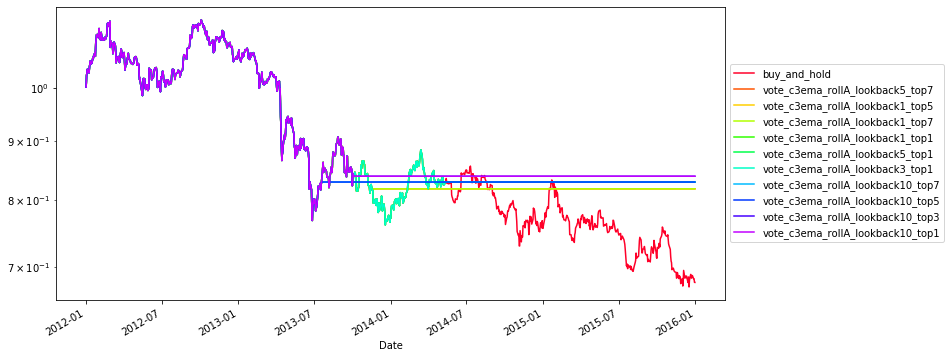

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback1_top1,0.539347,0.001921,0.510557,0.543298,1.261437
vote_c3ema_rollA_lookback3_top1,0.539347,0.001921,0.510557,0.543298,1.261437
vote_c3ema_rollA_lookback1_top3,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback3_top5,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback3_top3,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback1_top5,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback5_top5,0.638516,0.001921,0.518874,0.543086,1.253660
vote_c3ema_rollA_lookback5_top3,0.638516,0.001921,0.518874,0.543086,1.253660
vote_c3ema_rollA_lookback5_top1,0.521433,0.026248,0.513116,0.547239,1.251996


,annual_return,sharpe_ratio,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.066784,1.372467
vote_c3ema_rollA_lookback1_top1,0.032532,0.354775,-0.055088,0.590541
vote_c3ema_rollA_lookback3_top1,0.032532,0.354775,-0.055088,0.590541
vote_c3ema_rollA_lookback1_top3,0.034728,0.369491,-0.052298,0.664044
vote_c3ema_rollA_lookback3_top5,0.034728,0.369491,-0.052298,0.664044
vote_c3ema_rollA_lookback3_top3,0.034728,0.369491,-0.052298,0.664044
vote_c3ema_rollA_lookback1_top5,0.034728,0.369491,-0.052298,0.664044
vote_c3ema_rollA_lookback5_top5,0.040658,0.415701,-0.053586,0.758738
vote_c3ema_rollA_lookback5_top3,0.040658,0.415701,-0.053586,0.758738
vote_c3ema_rollA_lookback5_top1,0.043544,0.471489,-0.050861,0.856138


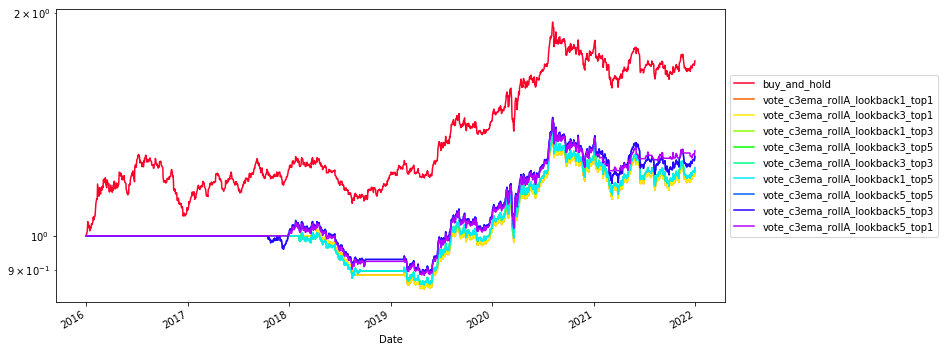

In [37]:
### roll only, return/avgdd top10
list_tmp = [x for x in ret_all.columns if (
    x=='buy_and_hold' 
    or 'vote_c3ema_' in x
)]
ret_tmp = ret_all[list_tmp]
print_all_result(ret_tmp)

print_all_result(ret_tmp['1988':'2000'])
print_all_result(ret_tmp['2001':'2011'])
print_all_result(ret_tmp['2012':'2015'])
print_all_result(ret_tmp['2016':'2021'])


In [ ]:
### all, return/avgdd top10
list_tmp = [x for x in ret_all.columns]
ret_tmp = ret_all[list_tmp]
print_all_result(ret_tmp)

print_all_result(ret_tmp['1988':'2000'])
print_all_result(ret_tmp['2001':'2011'])
print_all_result(ret_tmp['2012':'2015'])
print_all_result(ret_tmp['2016':'2021'])


In [ ]:
met_y

In [ ]:
pred_sub

In [ ]:
pred_sub.to_csv('pred_c3ema_roll_no_future.csv')